In [1]:
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd

df = pd.read_csv('/users/ouyang/desktop/CSE7324MachineLearning/Datasets/mobile-price-classification/train.csv')
df.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


## 2.1 Implementation of Logistic Regression

In [7]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.metrics import accuracy_score
from scipy.special import expit


In [8]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
from numpy.linalg import pinv
from scipy.optimize import fmin_bfgs

class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, optimization=1, 
                 regularization=2):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.optimization = optimization
        self.regularization = regularization
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    
    def _choose_regularization(self, gradient):
        regularization_num = [0, 1, 2, 3]
        '''
        0 for no regularization, 1 for L1, 2 for L2, 3 for L1&L2
        '''
        if self.regularization is regularization_num[0]:
            return gradient
        if self.regularization is regularization_num[1]:
            gradient += np.sign(self.w_[1:]) * self.C
            return gradient
        if self.regularization is regularization_num[2]:
            gradient += -2 * self.w_[1:] * self.C
            return gradient
        if self.regularization is regularization_num[3]:
            gradient += -2 * self.w_[1:] * self.C - np.sign(self.w_[1:]) * self.C
            return gradient 
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
#     # vectorized gradient calculation with regularization using L2 Norm
#     def _get_gradient(self,X,y):
#         ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
#         gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
#         gradient = gradient.reshape(self.w_.shape)
#         gradient[1:] += -2 * self.w_[1:] * self.C
#         return gradient
    
    def _get_gradient_steepest(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        return gradient
    
    def _update_w_steepest(self,X,y):
        for _ in range(self.iters):
            gradient = self._get_gradient_steepest(X,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
    
    # stochastic gradient calculation 
    def _get_gradient_stochastic(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] = self._choose_regularization(gradient[1:])
#         gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    def _update_w_stochasitc(self,X,y):
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient_stochastic(X,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            
    
    def _get_gradient_hessian(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] = self._choose_regularization(gradient[1:])
#         gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
    
    def _update_w_hessian(self,X,y):
        for _ in range(self.iters):
            gradient = self._get_gradient_hessian(X,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
    
    @staticmethod
    def BFGS_objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))
    
    @staticmethod
    def BFGS_objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        return -gradient
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # optionnumber represent the way we do optimization
        optimization_number=[1,2,3,4]
        # 1 for steepest descent. 2 for Stochastic Gradient Descent. 
        # 3 for Newton's Hessian, 4 for BGFS
        
################################################################
        if self.optimization is optimization_number[0]:
            # for as many as the max iterations
#             print('optimization 1')
            self._update_w_steepest(Xb, y) 
################################################################

################################################################
        if self.optimization is optimization_number[1]:
#             print('optimization 2')
            self._update_w_stochasitc(Xb, y)
################################################################

################################################################
        if self.optimization is optimization_number[2]:
#             print('optimization 3')
            self._update_w_hessian(Xb, y)
################################################################
        if self.optimization is optimization_number[3]:
#             print('optimization 4')
            self.w_ = fmin_bfgs(self.BFGS_objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.BFGS_objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
            self.w_ = self.w_.reshape((num_features,1))
################################################################    


# optimization=1 for Line Search. 2 for Stochastic Gradient Descent. 
# 3 for Newton's Hessian   
# blr = BinaryLogisticRegression(eta=0.1,iterations=5,C=0.001, 
#                                optimization=2, regularization=2)
# blr.fit(X,y)
# print(blr)

# yhat = blr.predict(X)
# print('Accuracy of: ',accuracy_score(y,yhat))

CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 40.8 µs


## Multiclass Logistic Regression

In [9]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, optimization=1,
                regularization=2):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.optimization = optimization
        self.regularization = regularization
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = BinaryLogisticRegression(self.eta,self.iters,self.C,self.optimization, 
                                            self.regularization)
            hblr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    


## Loading data

In [10]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('/users/ouyang/desktop/CSE7324MachineLearning/Datasets/mobile-price-classification/train.csv')
df.head(5)
X = np.array(df.iloc[:,:20])
y = np.array(df.iloc[:,-1])

X = StandardScaler().fit(X).transform(X)
y_not_binary = y

print(X.shape)
print(y_not_binary.shape)

(2000, 20)
(2000,)


## Cross Validation

In [76]:
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt

num_cv_iterations = 3
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2)

iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

Using cross validation, we can get different training dataset each time we run the code above.

# Below is testing

In [77]:
%%time
# when C is getting small, the accuracy increases
lr = MultiClassLogisticRegression(eta=0.1,iterations=1000,C=0.001, 
                                  optimization=1)
lr.fit(X_train,y_train)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

# 1500 iterations take 1 min 16 seconds

Accuracy of:  0.8025
CPU times: user 2.9 s, sys: 8.23 ms, total: 2.9 s
Wall time: 486 ms


In [80]:
%%time
# SGD need to take more steps, when C is getting small, the accuracy increases
lr = MultiClassLogisticRegression(eta=0.1,iterations=1000,C=0.001, 
                                  optimization=2, regularization=2)
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
# The accuracy of SDG is not fixed, about 70% when C=0.001

Accuracy of:  0.7
CPU times: user 70.8 ms, sys: 4.94 ms, total: 75.8 ms
Wall time: 71.2 ms


In [13]:
%%time
# Newton's method only needs a few iterations
lr = MultiClassLogisticRegression(eta=0.1,iterations=5,C=0.01, 
                                  optimization=3, regularization=2)
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
# The accuracy of Hessian is about 61%

Accuracy of:  0.6235
CPU times: user 1 s, sys: 108 ms, total: 1.11 s
Wall time: 194 ms


In [81]:
%%time
# BFGS method only needs a few iterations
lr = MultiClassLogisticRegression(eta=0.1,iterations=20,C=0.00001, 
                                  optimization=4, regularization=2)
lr.fit(X_train,y_train)
yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
# The accuracy of Hessian is about 61%

Accuracy of:  0.8575
CPU times: user 358 ms, sys: 2.4 ms, total: 360 ms
Wall time: 61.4 ms


# Testing ends
___

## 2.2

**Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?**

I think there is some "data snooping" involed in my method of selecting data, but it's ok because we use cross validation for selecting the train data of dataset. This time, we select different iterations, the value of C and the value of eta to get different accuracy and try to get the highest one. Besides, we don't have a detailed check of our data so we have no idea how it distributes. Therefore, I think we don't have a serious problem of "data snooping".

CPU times: user 7.26 s, sys: 22.1 ms, total: 7.29 s
Wall time: 1.22 s


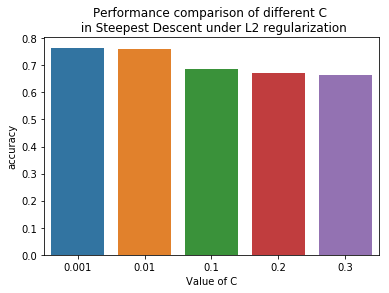

In [82]:
%%time
# Compare the performance of "Steepest Descent" with "L2 Regularization"
accuracy_list_sd = []
C_list_sd = [0.3, 0.2, 0.1, 0.01, 0.001]
for i in C_list_sd:
    lr = MultiClassLogisticRegression(eta=0.1,iterations=500,C=i, 
                                  optimization=1, regularization=2)
    lr.fit(X_train,y_train)
    yhat = lr.predict(X_test)
    accuracy_list_sd.append(accuracy_score(y_test,yhat))

import seaborn as sns
plt.xlabel("Value of C")
plt.ylabel("accuracy")
plt.title("Performance comparison of different C \n in Steepest Descent under L2 regularization")
g = sns.barplot(x=C_list_sd, y=accuracy_list_sd)

From the graph for Steepest Descent with L2 regularization above, we can see that when C is decreasing to about 0.01, the accuracy is around 76% and nearly stopping increasing, which means '0.01' is like a break point of the value of C.


CPU times: user 380 ms, sys: 5.26 ms, total: 386 ms
Wall time: 381 ms


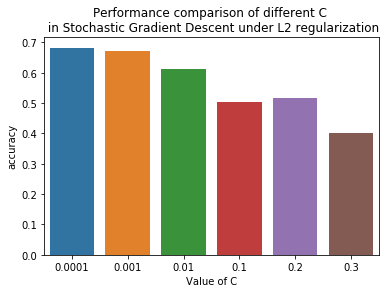

In [85]:
%%time
# Compare the performance of "Stochastic Gradient Descent" with "L2 Regularization"
accuracy_list_sgd = []
C_list_sgd = [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001]
for i in C_list_sgd:
    lr = MultiClassLogisticRegression(eta=0.1,iterations=1000,C=i, 
                                  optimization=2, regularization=2)
    lr.fit(X_train,y_train)
    yhat = lr.predict(X_test)
    accuracy_list_sgd.append(accuracy_score(y_test,yhat))

import seaborn as sns
plt.xlabel("Value of C")
plt.ylabel("accuracy")
plt.title("Performance comparison of different C \n in Stochastic Gradient Descent under L2 regularization")
g = sns.barplot(x=C_list_sgd, y=accuracy_list_sgd)

For the Stochastic Gradient Descent with L2 regularization, the accuracy is not stable. Sometimes the accuracy of "C=0.01" is even higher than the "C=0.001" one. From the graph above, we can get that the overall upper bound of accuracy is about 65% when C is around 0.01.

CPU times: user 2.35 s, sys: 138 ms, total: 2.49 s
Wall time: 420 ms


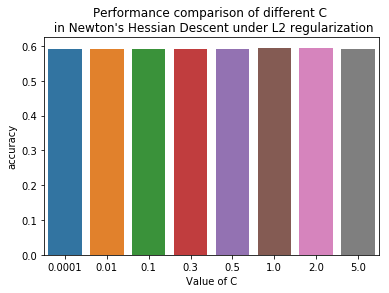

In [88]:
%%time
# Compare the performance of "Newton's Hessian Descent" with "L2 Regularization"
accuracy_list_nhd = []
C_list_nhd = [5, 2, 1, 0.5, 0.3, 0.1, 0.01,0.0001]
for i in C_list_nhd:
    lr = MultiClassLogisticRegression(eta=0.1,iterations=2,C=i, 
                                  optimization=3, regularization=3)
    lr.fit(X_train,y_train)
    yhat = lr.predict(X_test)
    accuracy_list_nhd.append(accuracy_score(y_test,yhat))

import seaborn as sns
plt.xlabel("Value of C")
plt.ylabel("accuracy")
plt.title("Performance comparison of different C \n in Newton's Hessian Descent under L2 regularization")
g = sns.barplot(x=C_list_nhd, y=accuracy_list_nhd)

The graph above is using Newton's Hessian optimization and L1&L2 regulatization. We can see that the accuracy remain stable at 85% when C is around or below 0.5. One interesting thing is that the accuracy of "C=2" is even higher than "C=1"

CPU times: user 2.98 s, sys: 7.46 ms, total: 2.99 s
Wall time: 502 ms


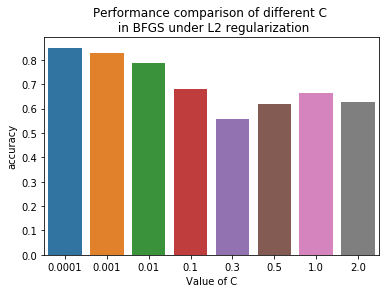

In [89]:
%%time
# Compare the performance of "BFGS" with "L2 Regularization"
accuracy_list_BFGS = []
C_list_BFGS = [2, 1, 0.5, 0.3, 0.1, 0.01, 0.001, 0.0001]
for i in C_list_BFGS:
    lr = MultiClassLogisticRegression(eta=0.1,iterations=50,C=i, 
                                  optimization=4, regularization=2)
    lr.fit(X_train,y_train)
    yhat = lr.predict(X_test)
    accuracy_list_BFGS.append(accuracy_score(y_test,yhat))

import seaborn as sns
plt.xlabel("Value of C")
plt.ylabel("accuracy")
plt.title("Performance comparison of different C \n in BFGS under L2 regularization")
g = sns.barplot(x=C_list_BFGS, y=accuracy_list_BFGS)

From the graph above that shows the relationship between C and accuracy of BFGS optimization, we can see that the overall accuracy is getting higher when C is getting smaller (when C is at 0.0001-0.1). The same weird thing happens again when C is between 0.5-1.0, at which the accuracy is also getting higher!

In [23]:
%%time
lr = MultiClassLogisticRegression(eta=0.1,iterations=10,C=0.01, 
                                  optimization=4, regularization=2)
lr.fit(X,y_not_binary)
yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y_not_binary,yhat))

Accuracy of:  0.7955
CPU times: user 453 ms, sys: 3.71 ms, total: 457 ms
Wall time: 79.7 ms


# Compare to scikit-learn

### Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results.

In [97]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

Accuracy of:  0.86


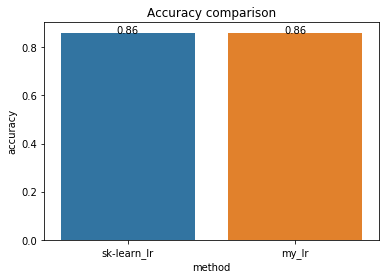

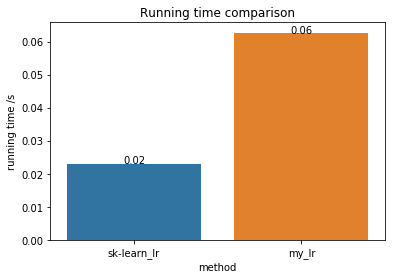

In [110]:
import time
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

running_time = []
# record the running time
start_sk = time.time()

# Use sklearn-traning
lr_sk = LogisticRegression(solver='lbfgs',n_jobs=1, C=1000) 
lr_sk.fit(X_train,y_train)
end_sk = time.time()
running_time.append(end_sk-start_sk)

yhat_sk = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat_sk))


#########################################################################################################
start_my = time.time()
lr_bfgs = MultiClassLogisticRegression(eta=0.1,iterations=20,C=0.00001, optimization=4, regularization=2)
lr_bfgs.fit(X_train, y_train)
end_my = time.time()
running_time.append(end_my-start_my)

yhat_lr = lr_bfgs.predict(X_test)
accuracy_bfgs = [accuracy_score(y_test,yhat_sk), accuracy_score(y_test,yhat_lr)]
method_list = ['sk-learn_lr', 'my_lr']

# plt.figure(figsize=(10,10))
fig, ax = plt.subplots(1, 1)

plt.title('Accuracy comparison')
plt.xlabel('method')
plt.ylabel('accuracy')
ax = sns.barplot(x=method_list, y=accuracy_bfgs)
show_values_on_bars(ax)


fig, ax = plt.subplots(1, 1)
plt.title('Running time comparison')
plt.xlabel('method')
plt.ylabel('running time /s')
ax = sns.barplot(x=method_list, y=running_time)
show_values_on_bars(ax)